In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from preprocess import Audio_Processor
import classifiers
import feature_reduce
import time
import data_utils as du
from sklearn import metrics
import dnn_classifier as dnn_clas

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [3]:
path_to_db='../ESC-50/'
preprocess = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset.

In [4]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50

In [5]:
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']

In [6]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


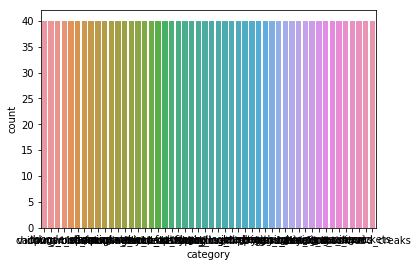

In [7]:
sns.countplot(dataset['category'])

## Preprocessing
Just MFCC were sufficient in previous work.
13 coefficients together with first and second derivatives and remove first energy component.
Should yield vector of 38 features per time frame.

In [8]:
test_file = preprocess.preprocess('1-100032-A-0.wav')

In [9]:
pd.DataFrame(test_file)

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,110.428156,-98.931606,-53.156196,-27.235981,-53.372091,-10.086893,-1.448754,10.022260,13.234096,10.227656,...,-0.007997,-0.001822,-0.021345,0.015144,-0.005421,0.034483,-0.003741,-0.007817,-0.012927,-0.010428
1,110.408779,-98.953512,-53.161059,-27.237148,-53.384993,-10.078167,-1.451851,10.042705,13.232514,10.222895,...,-0.007997,-0.001822,-0.021345,0.015144,-0.005421,0.034483,-0.003741,-0.007817,-0.012927,-0.010428
2,110.351071,-99.018894,-53.175530,-27.240616,-53.423344,-10.052009,-1.461010,10.103727,13.227877,10.208862,...,-0.007997,-0.001822,-0.021345,0.015144,-0.005421,0.034483,-0.003741,-0.007817,-0.012927,-0.010428
3,110.256343,-99.126526,-53.199071,-27.246173,-53.486214,-10.008699,-1.475921,10.204342,13.220258,10.186041,...,-0.007997,-0.001822,-0.021345,0.015144,-0.005421,0.034483,-0.003741,-0.007817,-0.012927,-0.010428
4,110.125951,-99.275288,-53.231513,-27.254043,-53.572631,-9.949132,-1.496604,10.342387,13.209272,10.154837,...,-0.007997,-0.001822,-0.021345,0.015144,-0.005421,0.034483,-0.003741,-0.007817,-0.012927,-0.010428
5,109.962716,-99.463181,-53.272040,-27.263815,-53.680796,-9.874159,-1.522717,10.515418,13.194455,10.115629,...,-0.007331,-0.001559,-0.019513,0.014054,-0.005176,0.031811,-0.003945,-0.007182,-0.011437,-0.009959
6,109.770179,-99.687702,-53.319596,-27.274887,-53.808413,-9.784641,-1.553767,10.720706,13.175552,10.069083,...,-0.006571,-0.001245,-0.017487,0.012834,-0.004895,0.028887,-0.004094,-0.006483,-0.009874,-0.009495
7,109.550871,-99.947333,-53.374218,-27.287619,-53.953966,-9.682542,-1.590149,10.954616,13.152071,10.015718,...,-0.005763,-0.000931,-0.015377,0.011541,-0.004591,0.025812,-0.004192,-0.005758,-0.008322,-0.009031
8,109.308474,-100.239335,-53.434801,-27.301265,-54.114858,-9.568926,-1.631160,11.214486,13.124570,9.956875,...,-0.004962,-0.000667,-0.013285,0.010220,-0.004279,0.022677,-0.004236,-0.005019,-0.006808,-0.008526
9,109.046993,-100.560460,-53.500025,-27.315185,-54.288667,-9.444960,-1.676203,11.497364,13.093203,9.893357,...,-0.004135,-0.000402,-0.011225,0.008956,-0.003932,0.019602,-0.004219,-0.004284,-0.005364,-0.007990


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
import pickle
def save_obj(obj, name ):
    with open('../preprocessed_objs/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('../preprocessed_objs/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def process_fold(fld):
    try:
        df = load_obj("fold_" + str(fld))
    except IOError:
        start_time = time.time()
        df = preprocess.preprocess_fold(fld, dataset, parallel=False)
        print("\tBytes: " + str(df.memory_usage(index=True).sum()))
        print("\tProcessing Time: " + str(time.time() - start_time))
        save_obj(df, "fold_" + str(fld))
    return df

In [11]:
c_data = pd.concat([process_fold(fld) for fld in range(1,6)], ignore_index=True)

In [12]:
n_categories = c_data.target.unique().size

In [13]:
c_data, scalar = du.normalize_data(c_data, 'target')
train, test = du.split_training_test(c_data, 0.2)
train_X = train.drop(columns=['target'])
train_y = train.target
test_X = test.drop(columns=['target'])
test_y = test.target

In [14]:
train.shape

(310994, 39)

## Overall DNN
Train overall net for classifying all categories

In [15]:
clas = dnn_clas.create_baseline()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 38)                1482      
_________________________________________________________________
dropout_1 (Dropout)          (None, 38)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 38)                1482      
_________________________________________________________________
dropout_2 (Dropout)          (None, 38)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                1950      
Total params: 4,914
Trainable params: 4,914
Non-trainable params: 0
_________________________________________________________________


In [16]:
dnn_clas.fit(clas, train_X, train_y, verbose=1)

Epoch 1/20
310994/310994 [==============================] - 25s 80us/step - loss: 3.1447 - acc: 0.1711
Epoch 2/20
310994/310994 [==============================] - 16s 51us/step - loss: 2.7351 - acc: 0.2584
Epoch 3/20
310994/310994 [==============================] - 16s 51us/step - loss: 2.6327 - acc: 0.2811
Epoch 4/20
310994/310994 [==============================] - 15s 49us/step - loss: 2.5870 - acc: 0.2909
Epoch 5/20
310994/310994 [==============================] - 15s 48us/step - loss: 2.5535 - acc: 0.2992
Epoch 6/20
310994/310994 [==============================] - 15s 48us/step - loss: 2.5377 - acc: 0.3024
Epoch 7/20
310994/310994 [==============================] - 15s 47us/step - loss: 2.5181 - acc: 0.3075
Epoch 8/20
310994/310994 [==============================] - 15s 48us/step - loss: 2.5094 - acc: 0.3102
Epoch 9/20
310994/310994 [==============================] - 15s 48us/step - loss: 2.5011 - acc: 0.3131
Epoch 10/20
310994/310994 [==============================] - 15s 49us/ste

In [17]:
dnn_clas.score(clas, test_X, test_y, verbose=1)

77749/77749 [==============================] - 119s 2ms/step
Test loss: 2.08641931449647
Test accuracy: 0.4369316647159449


## Scoring
Here we get the log likelihood of the categories when matched with its training data

In [ ]:
test = process_fold(5)
test, _ = du.normalize_data(test, 'target', scalar)
test_X = test.drop(columns=['target'])
test_y = test.target

In [ ]:
metrics.accuracy_score(test_y, list(clas.predict(test_X)))

In [ ]:
from classification_plots import plot_confusion_matrix
cm = metrics.confusion_matrix(test_y, list(clas.predict(test_X)))

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,25))
plot_confusion_matrix(cm, classes)

## Basic Probability of File Category
We run our classifier over the file's audio frames and use basic averages to determine the probability of it belonging to a class. (Should in future have classifier give probability scores for each category for each frame but... thats future work)

In [ ]:
print(classes)

In [ ]:
from collections import Counter
def file_probability(filename, clas, preprocessor, class_list):
    test_file = pd.DataFrame(preprocessor.preprocess(filename))
    predictions = [class_list[i] for i in list(clas.predict(test_file))]
    sns.countplot(predictions)
    c = Counter(predictions)
    return [(i, c[i] / len(predictions) * 100.0) for i, count in c.most_common()]

In [ ]:
plt.figure(figsize=(10,10))
file = dataset.filename.sample(n=1).values[0]
file_probability(file, clas, preprocess, classes)

In [ ]:
dataset[dataset.filename == file]